## Problem Definition
> How well can **PM10**, **SO$_{2}$** and **NO$_{2}$** concentration levels be estimated using various features in the data set?

## Data
The data was collected from [UCI ML Repository](https://archive.ics.uci.edu/dataset/501/beijing+multi+site+air+quality+data).
This data set includes hourly air pollutants data from 12 nationally-controlled air-quality monitoring sites. The air-quality data are from the Beijing Municipal Environmental Monitoring Center. The meteorological data in each air-quality site are matched with the nearest weather station from the China Meteorological Administration. The time period is from March 1st, 2013 to February 28th, 2017. Missing data are denoted as NA.

### License
This dataset is licensed under a Creative Commons Attribution 4.0 International (CC BY 4.0) license.

## Evaluation
For evaluation, we will use Root Mean Squared Error(RMSE), R$^{2}$ Score and Mean Absolute Error(MAE). For plotting, a residual plot and an actual vs. predicted plot is used.

Additionally, for XGBRegressor model, feautre importance is also looked up.

## Features
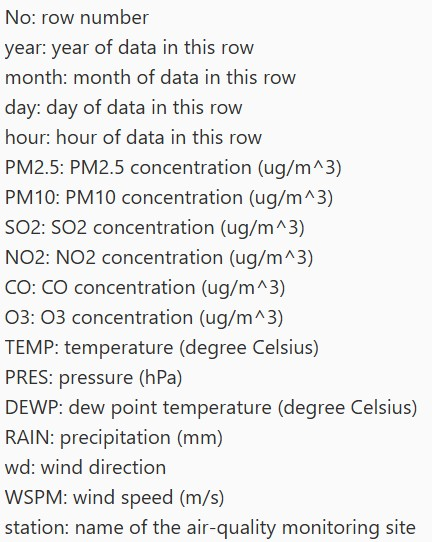

In [ ]:
# Install packages
!pip install missingno xgboost tensorflow statsmodels scikeras

In [ ]:
!pip install -U scikit-learn scikeras

In [ ]:
# Import necessary modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
%matplotlib inline

import missingno as msno

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer, RobustScaler, MinMaxScaler

from xgboost import plot_importance

from scikeras.wrappers import KerasRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input, Dropout, LSTM, Dense
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop

from statsmodels.graphics.tsaplots import plot_acf

import warnings
warnings.filterwarnings('ignore')

# Mounting google drive
from google.colab import drive
drive.mount('/content/Drive')

Drive already mounted at /content/Drive; to attempt to forcibly remount, call drive.mount("/content/Drive", force_remount=True).


In [ ]:
# Creating the dataframe
cities = ['Aotizhongxin', 'Changping', 'Dingling', 'Guanyuan', 'Huairou', 'Nongzhanguan', 'Shunyi', 'Tiantan','Wanshouxigong', 'Dongsi', 'Gucheng', 'Wanliu']
df = pd.concat([pd.read_csv(f'/content/Drive/MyDrive/Beijing_Multi_city/{city}.csv') for city in cities], ignore_index=True)

# Removing unnecessary feature "No"
df.drop('No', axis=1, inplace=True)

# Getting an overview
df.head()

,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
1,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
3,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
4,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin


## Data Cleaning

In [ ]:
# Getting an overview
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420768 entries, 0 to 420767
Data columns (total 17 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   year     420768 non-null  int64  
 1   month    420768 non-null  int64  
 2   day      420768 non-null  int64  
 3   hour     420768 non-null  int64  
 4   PM2.5    412029 non-null  float64
 5   PM10     414319 non-null  float64
 6   SO2      411747 non-null  float64
 7   NO2      408652 non-null  float64
 8   CO       400067 non-null  float64
 9   O3       407491 non-null  float64
 10  TEMP     420370 non-null  float64
 11  PRES     420375 non-null  float64
 12  DEWP     420365 non-null  float64
 13  RAIN     420378 non-null  float64
 14  wd       418946 non-null  object 
 15  WSPM     420450 non-null  float64
 16  station  420768 non-null  object 
dtypes: float64(11), int64(4), object(2)
memory usage: 54.6+ MB


In [ ]:
# Getting some info for numerical features
df.describe()

,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
count,420768.000000,420768.000000,420768.000000,420768.000000,412029.000000,414319.000000,411747.000000,408652.000000,400067.000000,407491.000000,420370.000000,420375.000000,420365.000000,420378.000000,420450.000000
mean,2014.662560,6.522930,15.729637,11.500000,79.793428,104.602618,15.830835,50.638586,1230.766454,57.372271,13.538976,1010.746982,2.490822,0.064476,1.729711
std,1.177198,3.448707,8.800102,6.922195,80.822391,91.772426,21.650603,35.127912,1160.182716,56.661607,11.436139,10.474055,13.793847,0.821004,1.246386
min,2013.000000,1.000000,1.000000,0.000000,2.000000,2.000000,0.285600,1.026500,100.000000,0.214200,-19.900000,982.400000,-43.400000,0.000000,0.000000
25%,2014.000000,4.000000,8.000000,5.750000,20.000000,36.000000,3.000000,23.000000,500.000000,11.000000,3.100000,1002.300000,-8.900000,0.000000,0.900000
50%,2015.000000,7.000000,16.000000,11.500000,55.000000,82.000000,7.000000,43.000000,900.000000,45.000000,14.500000,1010.400000,3.100000,0.000000,1.400000
75%,2016.000000,10.000000,23.000000,17.250000,111.000000,145.000000,20.000000,71.000000,1500.000000,82.000000,23.300000,1019.000000,15.100000,0.000000,2.200000
max,2017.000000,12.000000,31.000000,23.000000,999.000000,999.000000,500.000000,290.000000,10000.000000,1071.000000,41.600000,1042.800000,29.100000,72.500000,13.200000


In [ ]:
# Getting an overview for categorical features
df.describe(include='object')

,wd,station
count,418946,420768
unique,16,12
top,NE,Aotizhongxin
freq,43335,35064


In [ ]:
# Checking duplicated samples
df[df.duplicated()]

,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station


In [ ]:
# Checking missing values
df.isna().sum()

,0
year,0
month,0
day,0
hour,0
PM2.5,8739
PM10,6449
SO2,9021
NO2,12116
CO,20701
O3,13277


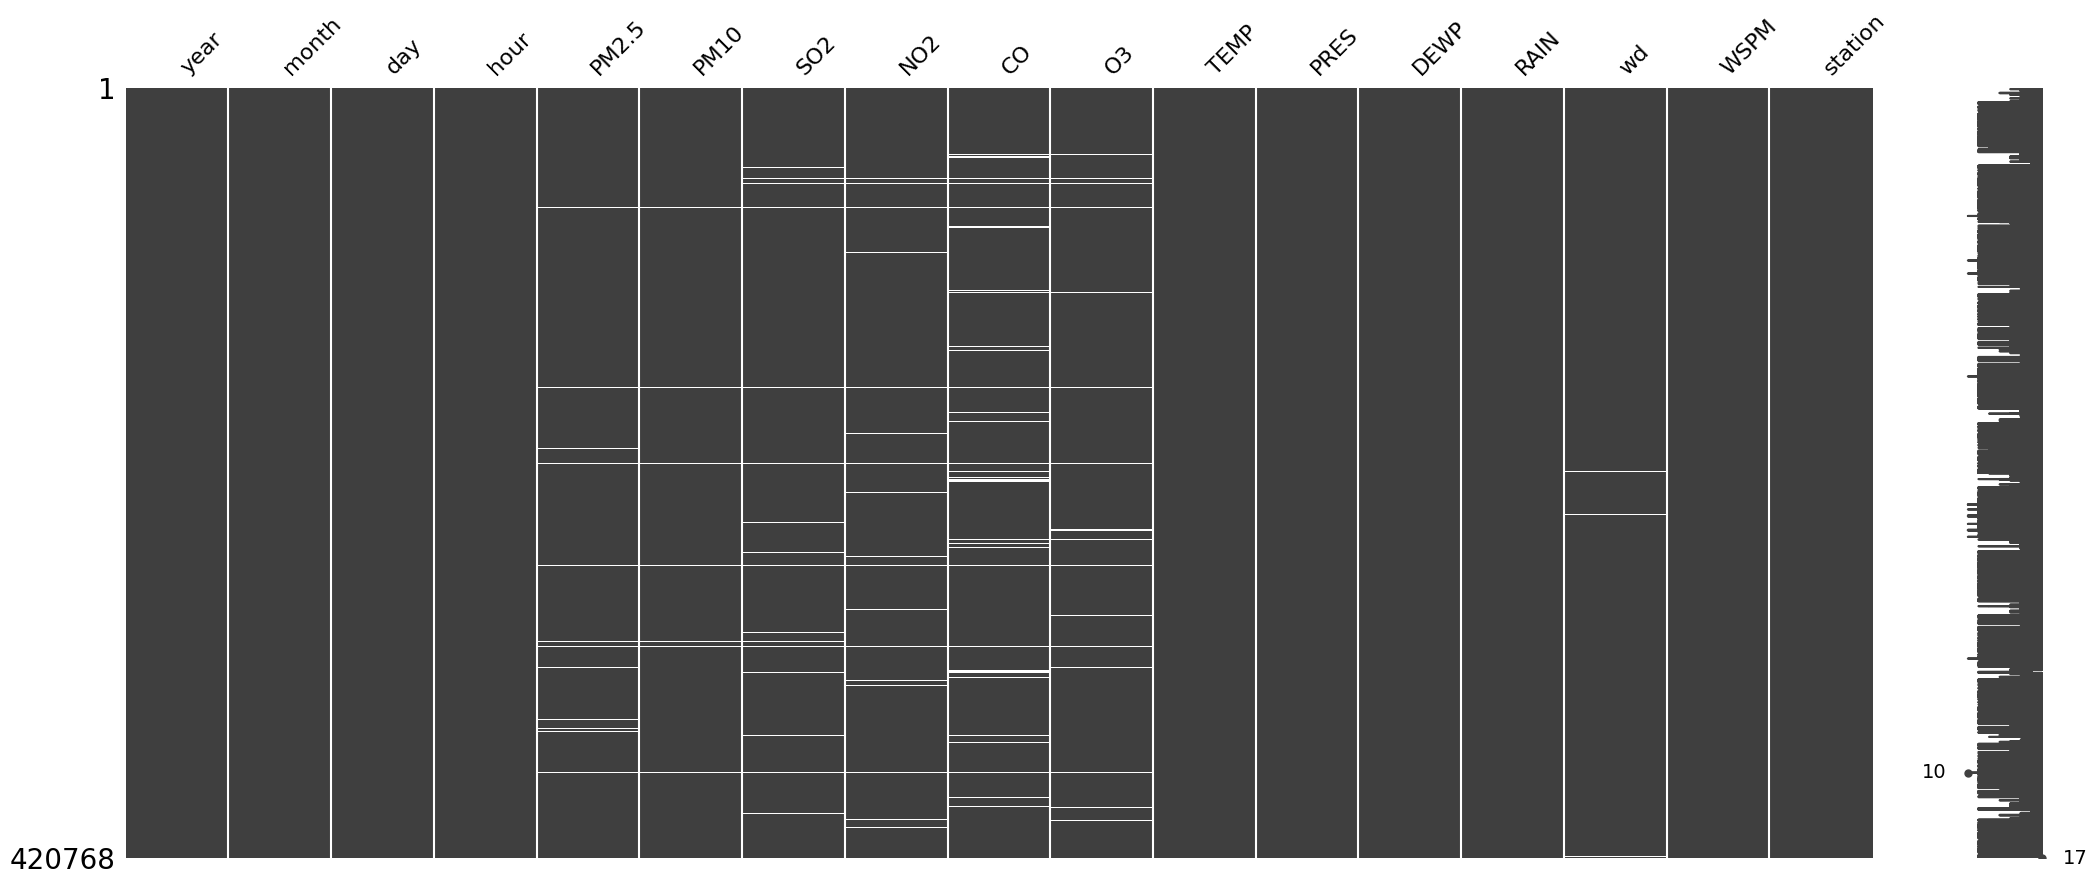

In [ ]:
# Cheking the places of missing values with missingno
msno.matrix(df)
plt.show()

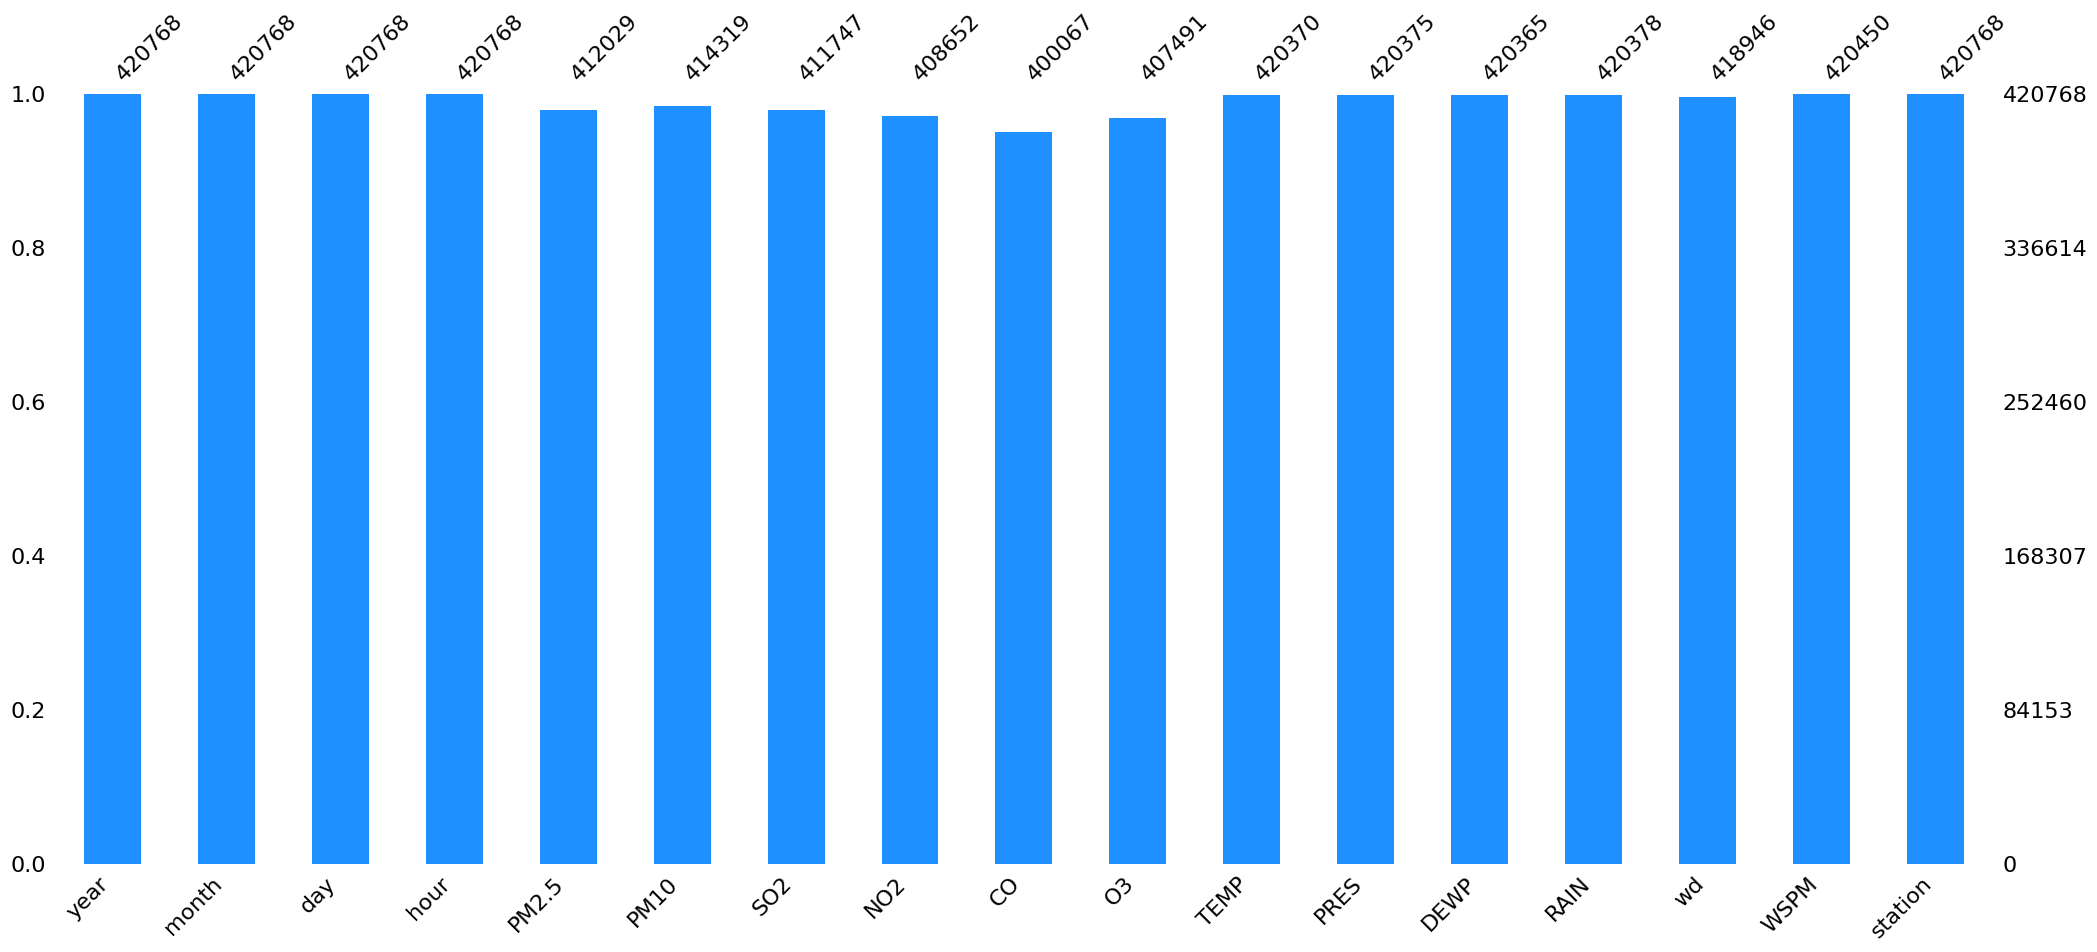

In [ ]:
# Checking the amount of missing values for various columns
msno.bar(df, color="dodgerblue")
plt.show()

Missing values are pretty small in amount and after all the dataset about 420k samples.

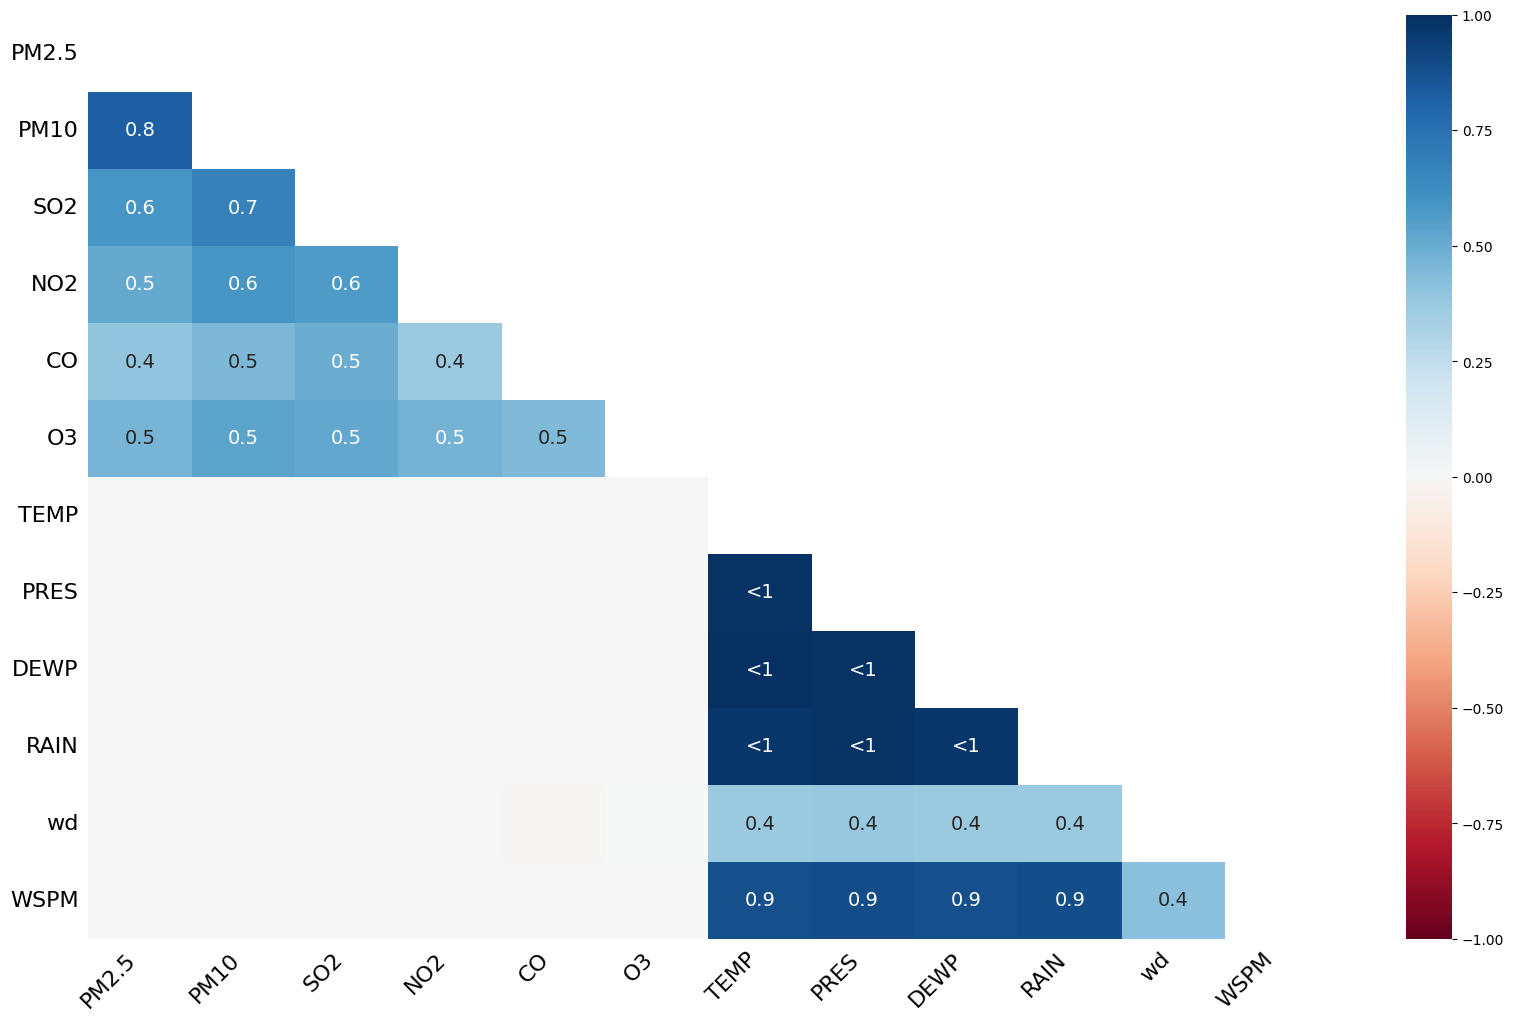

In [ ]:
# Correlation of missing values
msno.heatmap(df)
plt.show()

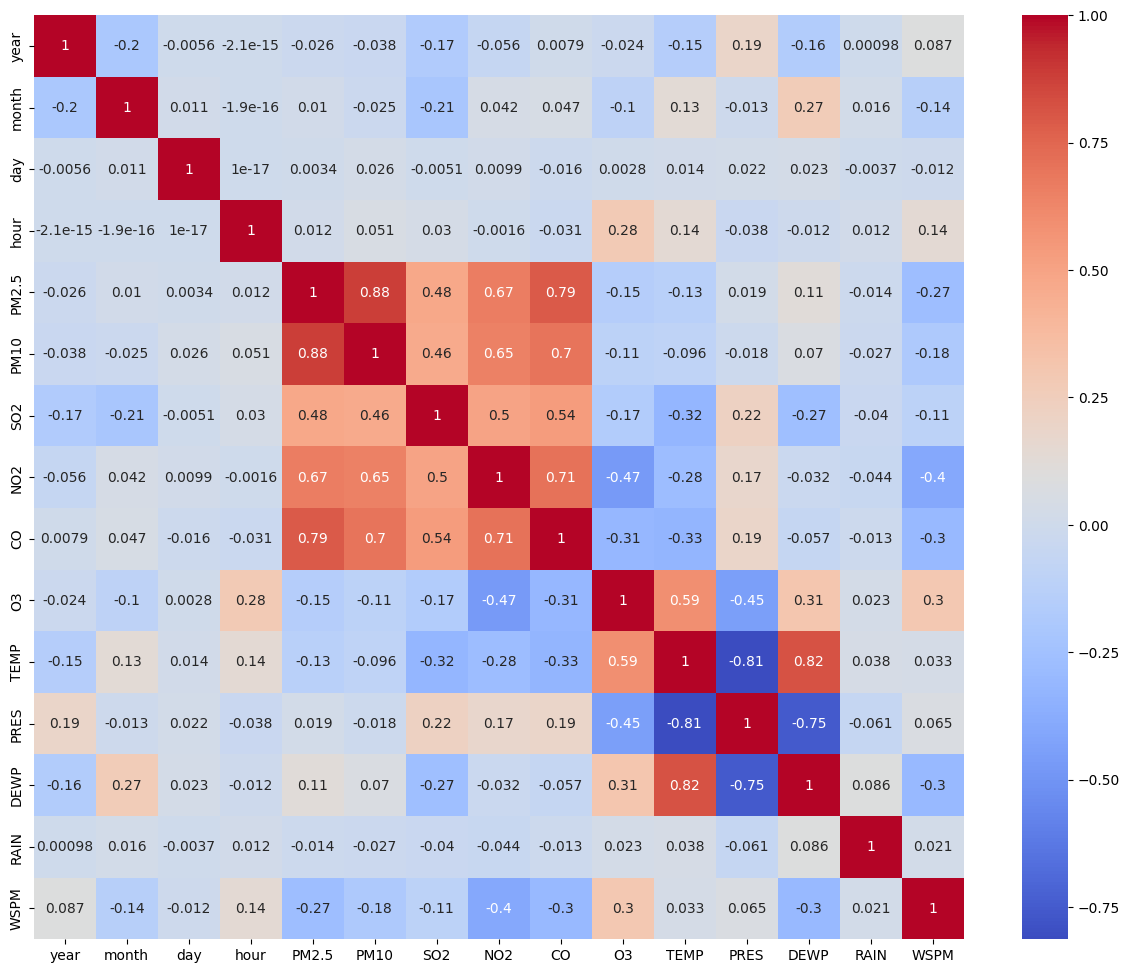

In [ ]:
# Visualizing bivariate correlations
plt.figure(figsize=(15, 12))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.show()

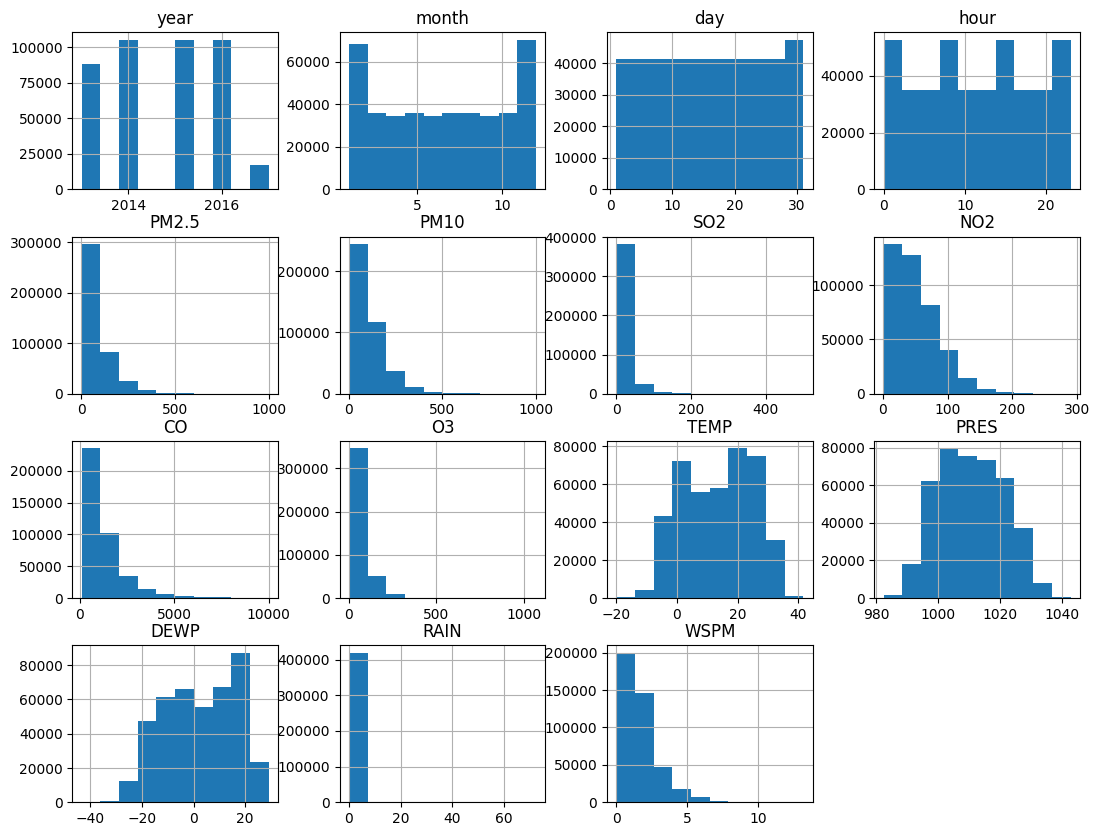

In [ ]:
# Distribution of various features
df.hist(figsize=(13, 10));

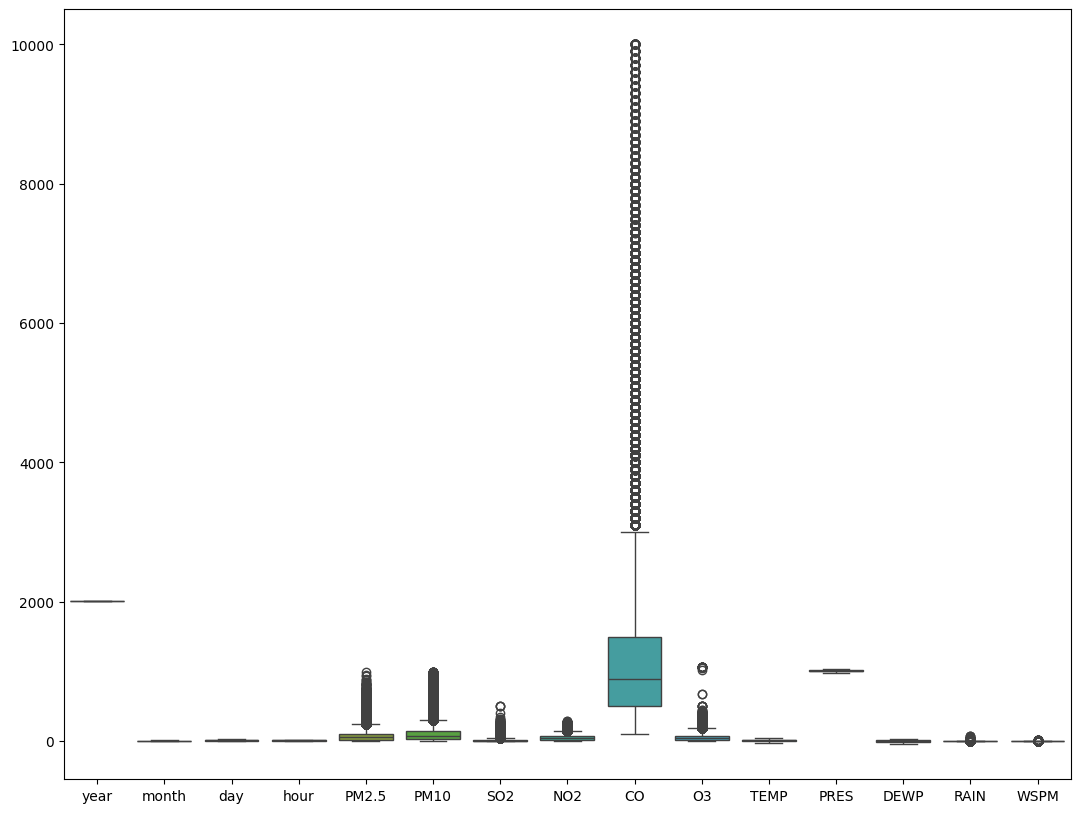

In [ ]:
# Checking outliers
plt.figure(figsize=(13, 10))
sns.boxplot(data=df)
plt.show()

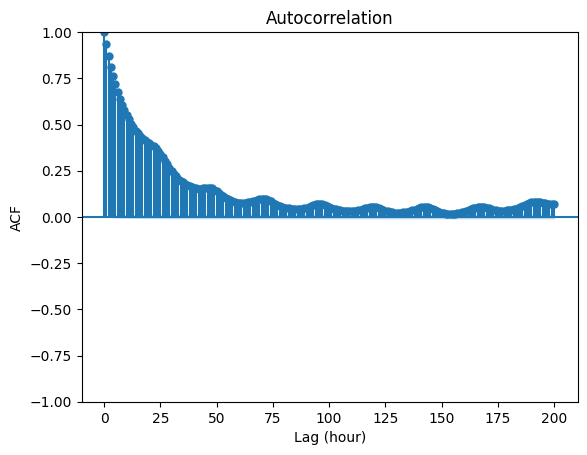

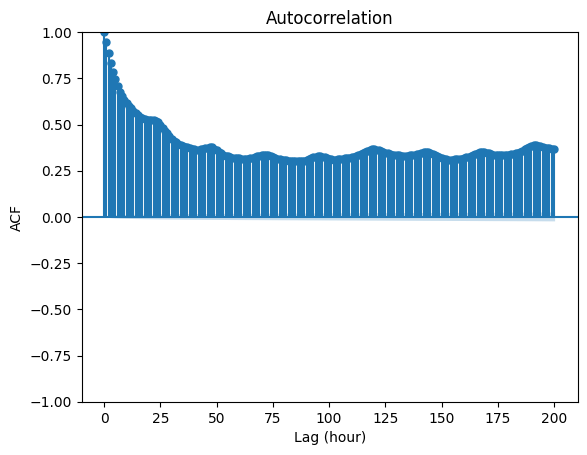

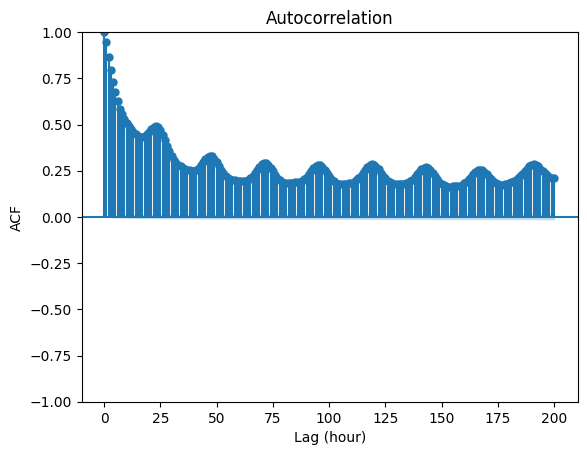

In [ ]:
# Name of the target features
targets = ['PM10', 'SO2', 'NO2']

# Checking autocorrelation of the targets to see whether they depend on the past values or not
for target in targets:
  plot_acf(df[target].dropna(), lags=200)
  plt.xlabel('Lag (hour)')
  plt.ylabel('ACF')
  plt.show()

In [ ]:
# Copy the dataframe for the alternative XGBRegressor model
df_xgb = df.copy()

In [ ]:
# Creating datetime feature
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])

# Sorting the samples based on datetime
df = df.sort_values('datetime')

# Set the datetime as index
df.set_index('datetime', inplace=True)

In [ ]:
# Drop the year feature
df.drop(['year'], axis=1, inplace=True)     # Doesn't involve much info

# Pollutants
pollutants = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3']

# Imputing pollutant concentrations with rolling average mean
for pollutant in pollutants:
  # Creating missing flags so that model treats imputed samples differently than recorded ones
  df[f'missing_flag_{pollutant}'] = df[pollutant].isna().astype(int)
  df[pollutant] = df[pollutant].fillna(df[pollutant].rolling(window=5, min_periods=1).mean().fillna(method='bfill').fillna(method='ffill'))

# Meteorological features
metero_features = ['TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']

# Time interpolation of the meterological features
for metero in metero_features:
  df[f'missing_flag_{metero}'] = df[metero].isna().astype(int)
  df[metero] = df[metero].interpolate('time')

In [ ]:
# Dropping the samples that is missing 'wd' only because rest of them are filled in already
df.dropna(inplace=True)

In [ ]:
# Checking if any missing values still exist
df.isna().sum().sum()

np.int64(0)

## Sequential Dense Neural Network

In [ ]:
def preprocess_weather_df(df):
    """
    Create sine and cosine components for
    month, day and hour cyclical features
    """
    # Cyclical encoding
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['day_sin']   = np.sin(2 * np.pi * df['day'] / 31)
    df['day_cos']   = np.cos(2 * np.pi * df['day'] / 31)

    # Drop original cyclical features
    df.drop(['month', 'hour', 'day'], axis=1, inplace=True)

    # Standardize selected features
    for col in ['TEMP', 'PRES', 'DEWP']:
        scaler = StandardScaler()
        df[col] = scaler.fit_transform(df[col].values.reshape(-1, 1))

    return df

In [ ]:
# Cyclical feature transformation
df = preprocess_weather_df(df)

# Pipeline for skewed features
pipeline = Pipeline([
    ('log', FunctionTransformer(np.log1p, validate=True)),
    ('scaler', RobustScaler())
])

# Pipeline for the target
pipeline2 = Pipeline([
    ('log2', FunctionTransformer(np.log1p, validate=True)),
    ('scaler2', MinMaxScaler())
])

In [ ]:
# Getting a copy of the dataframe for each pollutant
df_pm10 = df.copy()
df_so2 = df.copy()
df_no2 = df.copy()

In [ ]:
def scaling(target, df=df):
  """
  Transforms pollutant and meteorological
  features using suitable scalers and then
  encodes the categorcial features
  """

  # Skewed features in the dataframe
  skewed_features = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'RAIN', 'WSPM']
  skewed_features.remove(target)

  for feature in skewed_features:
    df[feature] = pipeline.fit_transform(df[feature].values.reshape(-1, 1))


  # Categorical columns
  cat_features = ['wd', 'station']

  # OnehotEncoder setup
  one_hot = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
  preprocessor = ColumnTransformer(
      transformers=[
          ('cat', one_hot, cat_features)
      ],
      remainder='passthrough'
  )

  # Transform the dataframe
  numpy_xgb = preprocessor.fit_transform(df)
  # Get feature names after transformation
  feature_names = list(preprocessor.get_feature_names_out())
  # Create a new DataFrame with the correct column names
  df = pd.DataFrame(numpy_xgb, columns=feature_names)

  X_train, X_test, y_train_scaled, y_test_scaled = splitting(target=target, df=df)
  return X_train, X_test, y_train_scaled, y_test_scaled

In [ ]:

def splitting(target, df):
  """
  Splits the dataset into X and y
  then creates X_train, X_test,
  y_train and y_test for 24 hour
  and scaling the target
  """

  # Deleting target to get input
  X = df.drop([f'remainder__{target}', f'remainder__missing_flag_{target}'], axis=1)

  # Extracting the targets
  y = df[f'remainder__{target}']

  def create_sequences(X, y, window_size):
      Xs, ys = [], []
      # Use iloc for positional indexing
      for i in range(len(X) - window_size):
          Xs.append(X.iloc[i:(i + window_size)].values)
          ys.append(y.iloc[i + window_size])
      return np.array(Xs), np.array(ys)

  window_size = 24  # 24 hours sequence
  X_seq, y_seq = create_sequences(X, y, window_size)

  # Splitting the dataset into train & test sets
  X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.3, shuffle=False, random_state=42)

  # Scaling the target
  y_train_scaled = pipeline2.fit_transform(y_train.reshape(-1, 1))
  y_test_scaled = pipeline2.transform(y_test.reshape(-1, 1))

  return X_train, X_test, y_train_scaled, y_test_scaled

In [ ]:
# Getting the train and test data for each pollutant
X_train_pm10, X_test_pm10, y_train_scaled_pm10, y_test_scaled_pm10 = scaling("PM10", df_pm10)
X_train_so2, X_test_so2, y_train_scaled_so2, y_test_scaled_so2 = scaling("SO2", df_so2)
X_train_no2, X_test_no2, y_train_scaled_no2, y_test_scaled_no2 = scaling("NO2", df_no2)

## Baseline Model

In [ ]:
def implement_model(X_train, X_test, y_train_scaled, y_test_scaled, target, units1, units2, dropout, epochs, batch_size, l_two, learning_rate, compare):
  """
  Trains the model
  """
  # Early stopping to tackle overfitting
  early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

  # Model architecture
  model = Sequential([
      Input(shape=(X_train.shape[1], X_train.shape[2])),
      LSTM(units1, return_sequences=True, activation='tanh', recurrent_dropout=0.3, kernel_regularizer=l2(l_two)),
      Dropout(dropout),
      LSTM(units2, activation='tanh', recurrent_dropout=0.3, kernel_regularizer=l2(l_two)),
      Dropout(dropout),
      Dense(1)
  ])

  # Print the model architecture
  print(model.summary())

  # Optimizer for the model
  optimizer = RMSprop(learning_rate=learning_rate)

  # Compile the model
  model.compile(
      optimizer=optimizer,
      loss='mse'
  )

  # Fit the model
  history = model.fit(X_train, y_train_scaled, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[early_stop])

  plt.figure(figsize=(8, 5))
  plt.plot(history.history['loss'], label='Training loss')
  plt.plot(history.history['val_loss'], label='Validation loss')
  plt.legend()
  plt.grid(alpha=0.4)
  plt.title(target)
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.tight_layout()
  plt.show()

  y_pred_scaled = model.predict(X_test, verbose=0)

  y_pred = pipeline2.inverse_transform(y_pred_scaled)
  y_true = pipeline2.inverse_transform(y_test_scaled.reshape(-1, 1))

  rmse = np.sqrt(mean_squared_error(y_true, y_pred))
  mae = mean_absolute_error(y_true, y_pred)
  r2 = r2_score(y_true, y_pred)

  print(f"RMSE: {rmse:.2f}")
  print(f"MAE: {mae:.2f}")
  print(f"R² Score: {r2:.2f}")

  if compare:
    plt.figure(figsize=(8, 5))
    plt.plot(y_pred[:100], label="Predicted", color='red')
    plt.plot(y_true[:100], label='Actual', color='green')
    plt.grid(alpha=0.3)
    plt.legend()
    plt.title(target)
    plt.xlabel('Data Samples')
    plt.ylabel('Pollutant Level')
    plt.tight_layout()
    plt.show()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 24, 64)         │        30,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,913 (167.63 KB)

 Trainable params: 42,913 (167.63 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/25
4124/4124 ━━━━━━━━━━━━━━━━━━━━ 121s 28ms/step - loss: 0.1929 - val_loss: 0.0080
Epoch 2/25
4124/4124 ━━━━━━━━━━━━━━━━━━━━ 114s 28ms/step - loss: 0.0114 - val_loss: 0.0076
Epoch 3/25
4124/4124 ━━━━━━━━━━━━━━━━━━━━ 117s 28ms/step - loss: 0.0109 - val_loss: 0.0122
Epoch 4/25
4124/4124 ━━━━━━━━━━━━━━━━━━━━ 114s 28ms/step - loss: 0.0109 - val_loss: 0.0087
Epoch 5/25
4124/4124 ━━━━━━━━━━━━━━━━━━━━ 114s 28ms/step - loss: 0.0107 - val_loss: 0.0083
Epoch 6/25
4124/4124 ━━━━━━━━━━━━━━━━━━━━ 115s 28ms/step - loss: 0.0105 - val_loss: 0.0115
Epoch 7/25
4124/4124 ━━━━━━━━━━━━━━━━━━━━ 115s 28ms/step - loss: 0.0103 - val_loss: 0.0078


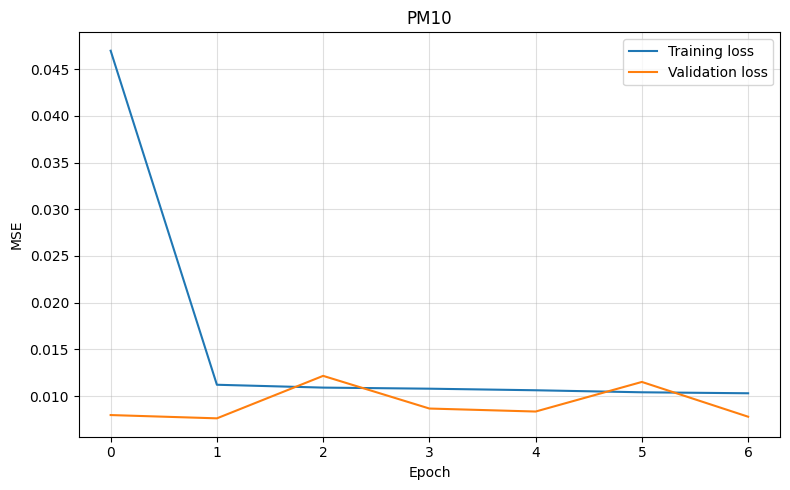

RMSE: 0.43
MAE: 0.32
R² Score: 0.74


In [ ]:
# For PM10
implement_model(
    X_train = X_train_pm10,
    X_test = X_test_pm10,
    y_train_scaled = y_train_scaled_pm10,
    y_test_scaled = y_test_scaled_pm10,
    target="PM10",
    units1=64,
    units2=32,
    dropout = 0.2,
    epochs = 25,
    batch_size = 64,
    l_two = 0.02,
    learning_rate = 0.001,
    compare = False)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 24, 64)         │        30,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,913 (167.63 KB)

 Trainable params: 42,913 (167.63 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/25
4124/4124 ━━━━━━━━━━━━━━━━━━━━ 117s 28ms/step - loss: 0.1923 - val_loss: 0.0124
Epoch 2/25
4124/4124 ━━━━━━━━━━━━━━━━━━━━ 113s 27ms/step - loss: 0.0130 - val_loss: 0.0166
Epoch 3/25
4124/4124 ━━━━━━━━━━━━━━━━━━━━ 115s 28ms/step - loss: 0.0128 - val_loss: 0.0139
Epoch 4/25
4124/4124 ━━━━━━━━━━━━━━━━━━━━ 115s 28ms/step - loss: 0.0124 - val_loss: 0.0124
Epoch 5/25
4124/4124 ━━━━━━━━━━━━━━━━━━━━ 111s 27ms/step - loss: 0.0122 - val_loss: 0.0133
Epoch 6/25
4124/4124 ━━━━━━━━━━━━━━━━━━━━ 113s 27ms/step - loss: 0.0122 - val_loss: 0.0125


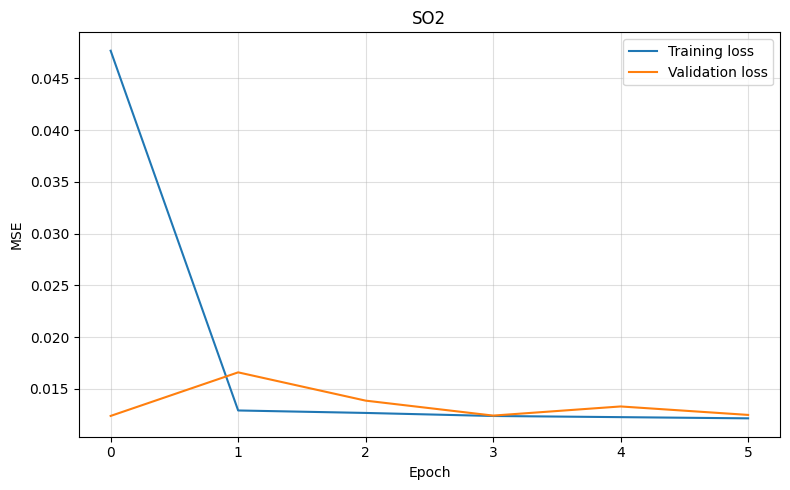

RMSE: 0.57
MAE: 0.47
R² Score: 0.45


In [ ]:
# For SO2
implement_model(
    X_train = X_train_so2,
    X_test = X_test_so2,
    y_train_scaled = y_train_scaled_so2,
    y_test_scaled = y_test_scaled_so2,
    target="SO2",
    units1=64,
    units2=32,
    dropout = 0.2,
    epochs = 25,
    batch_size = 64,
    l_two = 0.02,
    learning_rate = 0.001,
    compare = False)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 24, 64)         │        30,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,913 (167.63 KB)

 Trainable params: 42,913 (167.63 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/25
4124/4124 ━━━━━━━━━━━━━━━━━━━━ 117s 27ms/step - loss: 0.1949 - val_loss: 0.0128
Epoch 2/25
4124/4124 ━━━━━━━━━━━━━━━━━━━━ 114s 28ms/step - loss: 0.0139 - val_loss: 0.0125
Epoch 3/25
4124/4124 ━━━━━━━━━━━━━━━━━━━━ 113s 27ms/step - loss: 0.0137 - val_loss: 0.0127
Epoch 4/25
4124/4124 ━━━━━━━━━━━━━━━━━━━━ 114s 28ms/step - loss: 0.0136 - val_loss: 0.0124
Epoch 5/25
4124/4124 ━━━━━━━━━━━━━━━━━━━━ 113s 27ms/step - loss: 0.0134 - val_loss: 0.0125
Epoch 6/25
4124/4124 ━━━━━━━━━━━━━━━━━━━━ 109s 26ms/step - loss: 0.0135 - val_loss: 0.0120
Epoch 7/25
4124/4124 ━━━━━━━━━━━━━━━━━━━━ 113s 27ms/step - loss: 0.0134 - val_loss: 0.0128
Epoch 8/25
4124/4124 ━━━━━━━━━━━━━━━━━━━━ 113s 27ms/step - loss: 0.0133 - val_loss: 0.0126
Epoch 9/25
4124/4124 ━━━━━━━━━━━━━━━━━━━━ 113s 27ms/step - loss: 0.0132 - val_loss: 0.0126
Epoch 10/25
4124/4124 ━━━━━━━━━━━━━━━━━━━━ 114s 28ms/step - loss: 0.0132 - val_loss: 0.0119
Epoch 11/25
4124/4124 ━━━━━━━━━━━━━━━━━━━━ 113s 27ms/step - loss: 0.0131 - val_loss:

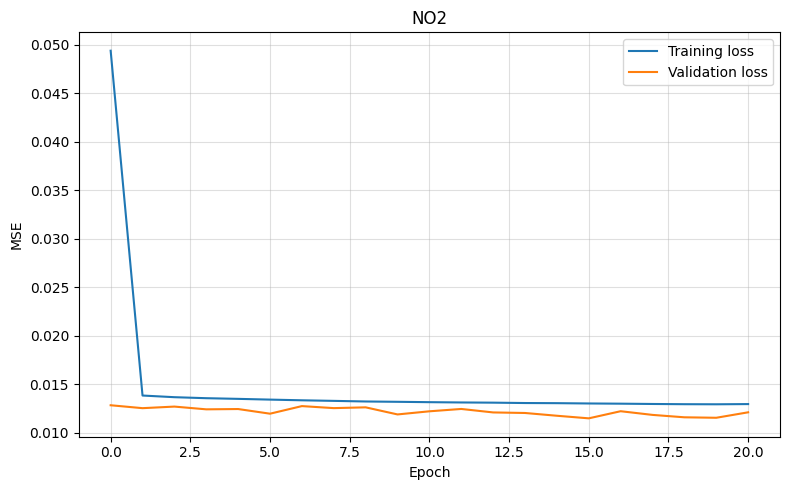

RMSE: 0.57
MAE: 0.41
R² Score: 0.54


In [ ]:
# For NO2
implement_model(
    X_train = X_train_no2,
    X_test = X_test_no2,
    y_train_scaled = y_train_scaled_no2,
    y_test_scaled = y_test_scaled_no2,
    target="NO2",
    units1=64,
    units2=32,
    dropout = 0.2,
    epochs = 25,
    batch_size = 64,
    l_two = 0.02,
    learning_rate = 0.001,
    compare = False)

## Hyperparameter Optimization

In [ ]:
"""
def build_model(units1=128, units2=64, units3=32, dropout_rate=0.3, l2_rate=0.001, learning_rate=0.001):

      model = Sequential([
      Input(shape=(X_train.shape[1], X_train.shape[2])),
      LSTM(units1, return_sequences=True, activation='tanh', recurrent_dropout=0.3, kernel_regularizer=l2(l2_rate)),
      Dropout(dropout_rate),
      LSTM(units2, activation='tanh', recurrent_dropout=0.3, kernel_regularizer=l2(l2_rate)),
      Dropout(dropout_rate),
      Dense(1)
     ])
      model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate), loss='mse')
      return model


reg = KerasRegressor(model=build_model, verbose=0)


param_dist = {
    "model__units1": [32, 64],
    "model__units2": [16, 32],
    "model__dropout_rate": [0.2, 0.3, 0.4],
    "model__l2_rate": [0.001, 0.01, 0.1],
    "model__learning_rate": [1e-4, 1e-3, 1e-2],
    "fit__batch_size": [32, 64],
    "fit__epochs": [15, 25]
}

search = RandomizedSearchCV(estimator=reg,
                            param_distributions=param_dist,
                            n_iter=10,  # Number of combinations to try
                            cv=3,       # Cross-validation folds
                            verbose=2,
                            n_jobs=-1)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
search.fit(X_train, y_train_scaled, callbacks=[early_stop],  validation_split=0.1)
"""

'\ndef build_model(units1=128, units2=64, units3=32, dropout_rate=0.3, l2_rate=0.001, learning_rate=0.001):\n\n      model = Sequential([\n      Input(shape=(X_train.shape[1], X_train.shape[2])),\n      LSTM(units1, return_sequences=True, activation=\'tanh\', recurrent_dropout=0.3, kernel_regularizer=l2(l2_rate)),\n      Dropout(dropout_rate),\n      LSTM(units2, activation=\'tanh\', recurrent_dropout=0.3, kernel_regularizer=l2(l2_rate)),\n      Dropout(dropout_rate),\n      Dense(1)\n     ])\n      model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate), loss=\'mse\')\n      return model\n      \n\nreg = KerasRegressor(model=build_model, verbose=0)\n\n\nparam_dist = {\n    "model__units1": [32, 64],\n    "model__units2": [16, 32],\n    "model__dropout_rate": [0.2, 0.3, 0.4],\n    "model__l2_rate": [0.001, 0.01, 0.1],\n    "model__learning_rate": [1e-4, 1e-3, 1e-2],\n    "fit__batch_size": [32, 64],\n    "fit__epochs": [15, 25]\n}\n\nsearch = RandomizedSearchCV

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 24, 64)         │        30,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 16)             │         5,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,665 (139.32 KB)

 Trainable params: 35,665 (139.32 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/25
8248/8248 ━━━━━━━━━━━━━━━━━━━━ 211s 25ms/step - loss: 0.1033 - val_loss: 0.0096
Epoch 2/25
8248/8248 ━━━━━━━━━━━━━━━━━━━━ 207s 25ms/step - loss: 0.0116 - val_loss: 0.0078
Epoch 3/25
8248/8248 ━━━━━━━━━━━━━━━━━━━━ 208s 25ms/step - loss: 0.0098 - val_loss: 0.0079
Epoch 4/25
8248/8248 ━━━━━━━━━━━━━━━━━━━━ 208s 25ms/step - loss: 0.0094 - val_loss: 0.0072
Epoch 5/25
8248/8248 ━━━━━━━━━━━━━━━━━━━━ 208s 25ms/step - loss: 0.0093 - val_loss: 0.0073
Epoch 6/25
8248/8248 ━━━━━━━━━━━━━━━━━━━━ 207s 25ms/step - loss: 0.0093 - val_loss: 0.0082
Epoch 7/25
8248/8248 ━━━━━━━━━━━━━━━━━━━━ 205s 25ms/step - loss: 0.0092 - val_loss: 0.0088
Epoch 8/25
8248/8248 ━━━━━━━━━━━━━━━━━━━━ 207s 25ms/step - loss: 0.0091 - val_loss: 0.0078
Epoch 9/25
8248/8248 ━━━━━━━━━━━━━━━━━━━━ 207s 25ms/step - loss: 0.0091 - val_loss: 0.0076


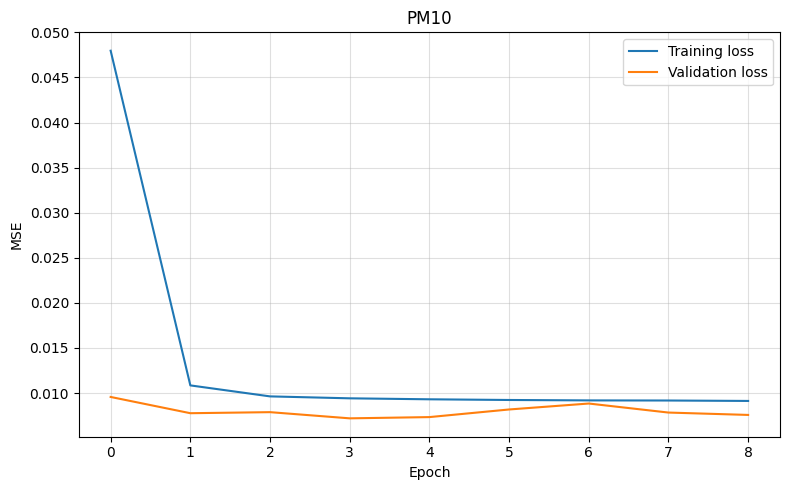

RMSE: 0.42
MAE: 0.31
R² Score: 0.75


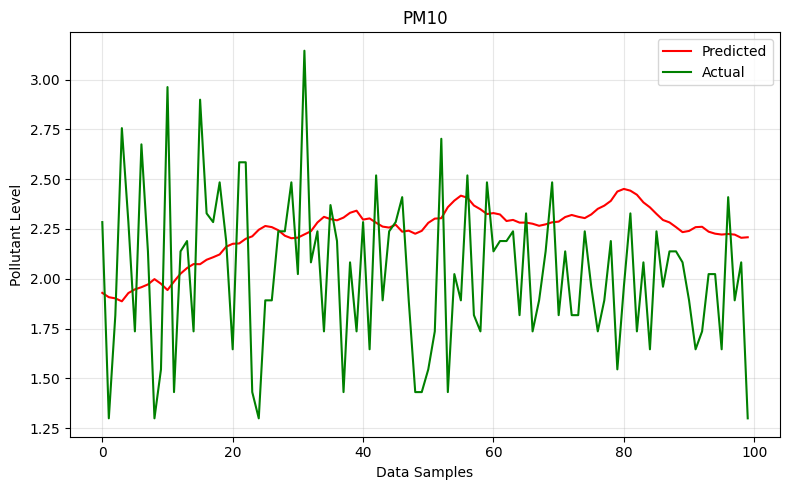

In [ ]:
# For PM10 with best hyperparameters
implement_model(
    X_train = X_train_pm10,
    X_test = X_test_pm10,
    y_train_scaled = y_train_scaled_pm10,
    y_test_scaled = y_test_scaled_pm10,
    target="PM10",
    units1=64,
    units2=16,
    dropout = 0.3,
    epochs = 25,
    batch_size = 32,
    l_two = 0.001,
    learning_rate = 0.0001,
    compare = True)

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                  │ (None, 24, 32)         │        11,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 24, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,289 (55.82 KB)

 Trainable params: 14,289 (55.82 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/25
8248/8248 ━━━━━━━━━━━━━━━━━━━━ 206s 24ms/step - loss: 0.0642 - val_loss: 0.0155
Epoch 2/25
8248/8248 ━━━━━━━━━━━━━━━━━━━━ 200s 24ms/step - loss: 0.0124 - val_loss: 0.0109
Epoch 3/25
8248/8248 ━━━━━━━━━━━━━━━━━━━━ 198s 24ms/step - loss: 0.0117 - val_loss: 0.0150
Epoch 4/25
8248/8248 ━━━━━━━━━━━━━━━━━━━━ 202s 25ms/step - loss: 0.0116 - val_loss: 0.0097
Epoch 5/25
8248/8248 ━━━━━━━━━━━━━━━━━━━━ 200s 24ms/step - loss: 0.0116 - val_loss: 0.0149
Epoch 6/25
8248/8248 ━━━━━━━━━━━━━━━━━━━━ 198s 24ms/step - loss: 0.0115 - val_loss: 0.0110
Epoch 7/25
8248/8248 ━━━━━━━━━━━━━━━━━━━━ 201s 24ms/step - loss: 0.0114 - val_loss: 0.0115
Epoch 8/25
8248/8248 ━━━━━━━━━━━━━━━━━━━━ 204s 25ms/step - loss: 0.0114 - val_loss: 0.0120
Epoch 9/25
8248/8248 ━━━━━━━━━━━━━━━━━━━━ 196s 24ms/step - loss: 0.0114 - val_loss: 0.0101


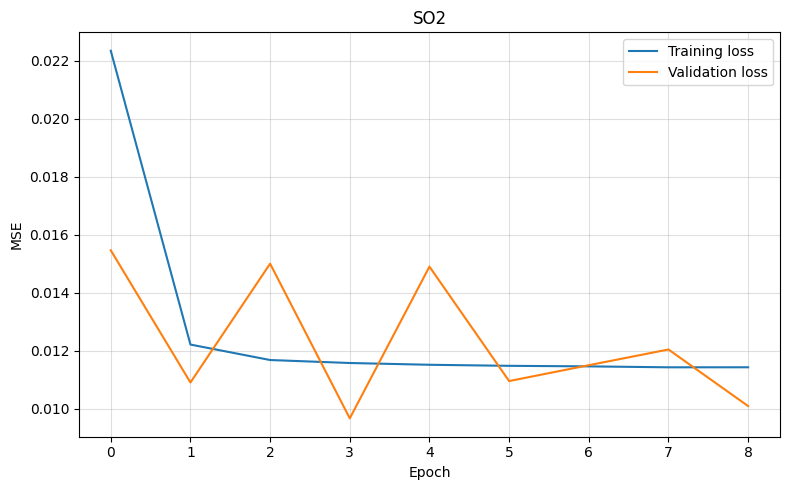

RMSE: 0.55
MAE: 0.43
R² Score: 0.47


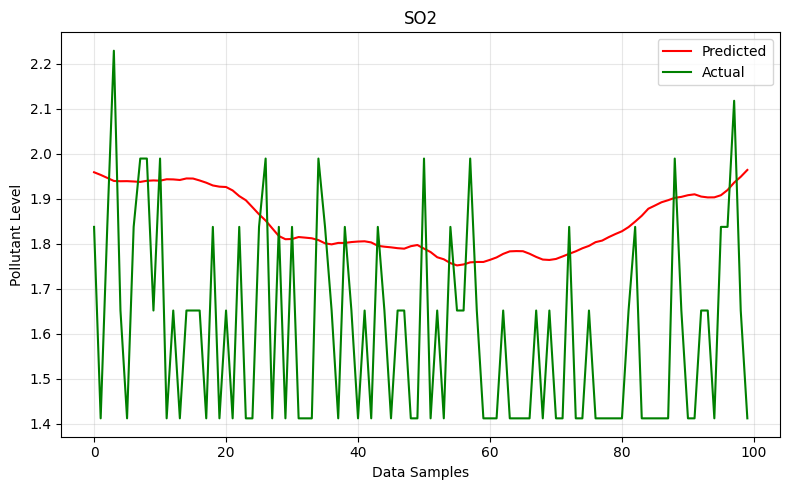

In [ ]:
# For SO2 with best hyperparameters
implement_model(
    X_train = X_train_so2,
    X_test = X_test_so2,
    y_train_scaled = y_train_scaled_so2,
    y_test_scaled = y_test_scaled_so2,
    target="SO2",
    units1=32,
    units2=16,
    dropout = 0.2,
    epochs = 25,
    batch_size = 32,
    l_two = 0.01,
    learning_rate = 0.001,
    compare = True)

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                  │ (None, 24, 64)         │        30,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,913 (167.63 KB)

 Trainable params: 42,913 (167.63 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/15
8248/8248 ━━━━━━━━━━━━━━━━━━━━ 214s 25ms/step - loss: 0.0314 - val_loss: 0.0115
Epoch 2/15
8248/8248 ━━━━━━━━━━━━━━━━━━━━ 213s 26ms/step - loss: 0.0125 - val_loss: 0.0111
Epoch 3/15
8248/8248 ━━━━━━━━━━━━━━━━━━━━ 215s 26ms/step - loss: 0.0124 - val_loss: 0.0109
Epoch 4/15
8248/8248 ━━━━━━━━━━━━━━━━━━━━ 213s 26ms/step - loss: 0.0124 - val_loss: 0.0112
Epoch 5/15
8248/8248 ━━━━━━━━━━━━━━━━━━━━ 213s 26ms/step - loss: 0.0123 - val_loss: 0.0110
Epoch 6/15
8248/8248 ━━━━━━━━━━━━━━━━━━━━ 216s 26ms/step - loss: 0.0122 - val_loss: 0.0108
Epoch 7/15
8248/8248 ━━━━━━━━━━━━━━━━━━━━ 214s 26ms/step - loss: 0.0123 - val_loss: 0.0116
Epoch 8/15
8248/8248 ━━━━━━━━━━━━━━━━━━━━ 212s 26ms/step - loss: 0.0123 - val_loss: 0.0110
Epoch 9/15
8248/8248 ━━━━━━━━━━━━━━━━━━━━ 212s 26ms/step - loss: 0.0122 - val_loss: 0.0119
Epoch 10/15
8248/8248 ━━━━━━━━━━━━━━━━━━━━ 206s 25ms/step - loss: 0.0122 - val_loss: 0.0109
Epoch 11/15
8248/8248 ━━━━━━━━━━━━━━━━━━━━ 210s 25ms/step - loss: 0.0122 - val_loss:

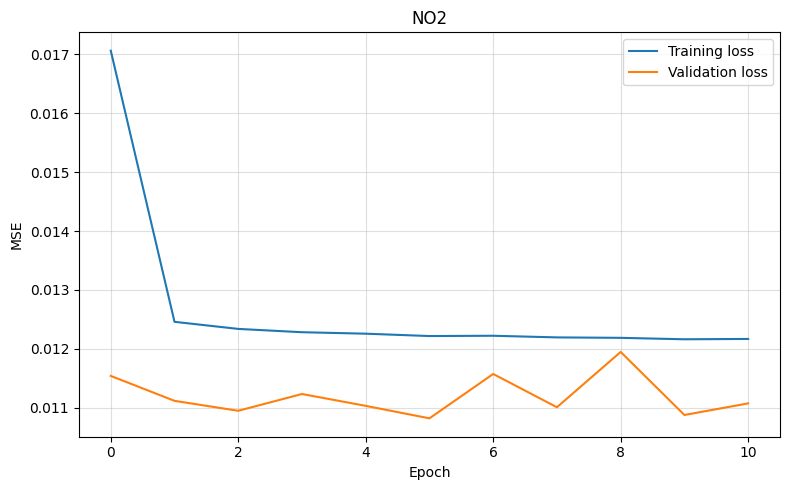

RMSE: 0.55
MAE: 0.40
R² Score: 0.57


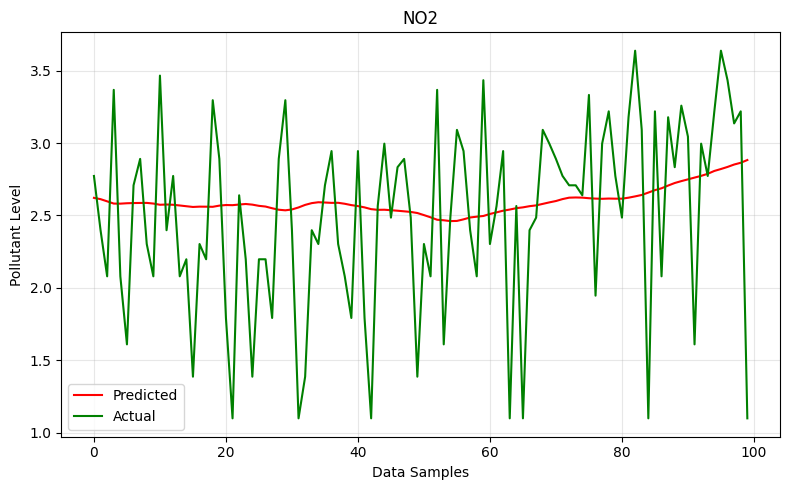

In [ ]:
# For NO2 with best hyperparameters
implement_model(
    X_train = X_train_no2,
    X_test = X_test_no2,
    y_train_scaled = y_train_scaled_no2,
    y_test_scaled = y_test_scaled_no2,
    target="NO2",
    units1=64,
    units2=32,
    dropout = 0.2,
    epochs = 15,
    batch_size = 32,
    l_two = 0.001,
    learning_rate = 0.001,
    compare = True)

# XGBoost

In [ ]:
# Checking the percentage of missing values in total
missing = (df_xgb.shape[0] - df_xgb.dropna().shape[0]) * 100/df_xgb.shape[0]
print(f"The percentage of missing values is {missing:.2f}%")

The percentage of missing values is 9.17%


Since, it is less than 10%, we can drop the missing samples without harming the XGBRegressor model. XGBRegressor doesn't require sequential data, hence droping the missing samples will not harm not the model.

In [ ]:
# Droping all the missing rows
df_xgb.dropna(inplace=True)

In [ ]:
# Encoding the categorical features

# Categorical columns
cat_features = ['wd', 'station']

# OnehotEncoder setup
one_hot = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', one_hot, cat_features)
    ],
    remainder='passthrough'
)

# Transform the dataframe
numpy_xgb = preprocessor.fit_transform(df_xgb)
# Get feature names after transformation
feature_names = list(preprocessor.get_feature_names_out())
# Create a new DataFrame with the correct column names
df_xgboost = pd.DataFrame(numpy_xgb, columns=feature_names)
df_xgboost.head()

,cat__wd_E,cat__wd_ENE,cat__wd_ESE,cat__wd_N,cat__wd_NE,cat__wd_NNE,cat__wd_NNW,cat__wd_NW,cat__wd_S,cat__wd_SE,...,remainder__PM10,remainder__SO2,remainder__NO2,remainder__CO,remainder__O3,remainder__TEMP,remainder__PRES,remainder__DEWP,remainder__RAIN,remainder__WSPM
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,4.4
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,4.7
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,5.6
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,3.1
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,2.0


## Splitting Dataset

In [ ]:
def split_dataset(df, target, random_state=42, train_size=0.6, test_size=0.5):
  """
  This function firstly splits the dataset into inputs and targets
  and secondly it splits those into training, testing and validation parts.
  """
  # Deleting target to get input
  X = df.drop([target], axis=1)

  # Extracting the targets
  y = df[target]

  # Splitting between training, test and validation dataset for PM10
  X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=train_size)
  X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, random_state=random_state, test_size=test_size)

  return X_train, X_val, X_test, y_train, y_val, y_test

In [ ]:
# Getting the training, testing and validation datasets
X_xgb_pm10_train, X_xgb_pm10_val, X_xgb_pm10_test, y_xgb_pm10_train, y_xgb_pm10_val, y_xgb_pm10_test = split_dataset(df_xgboost, 'remainder__PM10')
X_xgb_so2_train,  X_xgb_so2_val,  X_xgb_so2_test,  y_xgb_so2_train,  y_xgb_so2_val,  y_xgb_so2_test  = split_dataset(df_xgboost, 'remainder__SO2')
X_xgb_no2_train,  X_xgb_no2_val,  X_xgb_no2_test,  y_xgb_no2_train,  y_xgb_no2_val,  y_xgb_no2_test  = split_dataset(df_xgboost, 'remainder__NO2')

## Baseline Model

In [ ]:
# Initiating a dataframe to absorb all the metrics
baseline_evaluation = pd.DataFrame(
    index=["PM10 Training", "PM10 Validation", "SO2 Training", "SO2 Validation", "NO2 Training", "NO2 Validation"],
    columns=["MAE", "RMSE", "R^2"]
)

mae = []
r2 = []
rmse = []

# Function for fitting and evaluation
def fit_and_evaluate(X_train, y_train, X_val, y_val, title):
  """
  This function fits data into the model, obtain
  some evaluation metrics for both trianing and
  validation sets and evalutes the traingin vs
  validation loss to check overfitting/underfitting.
  """

  # Fit model
  xgb = XGBRegressor(random_state=42, early_stopping_rounds=30)
  xgb.fit(X_train, y_train, verbose=False, eval_set=[(X_train, y_train), (X_val, y_val)])

  # Predict
  y_train_pred = xgb.predict(X_train)
  y_val_pred = xgb.predict(X_val)

  # Predict evaluation metrics for training set
  mae.append(round(mean_absolute_error(y_train, y_train_pred), 2))
  rmse.append(round(np.sqrt(mean_absolute_error(y_train, y_train_pred)), 2))
  r2.append(round(r2_score(y_train, y_train_pred), 2))

  # Predict evaluation metrics for validation set
  mae.append(round(mean_absolute_error(y_val, y_val_pred), 2))
  rmse.append(round(np.sqrt(mean_absolute_error(y_val, y_val_pred)), 2))
  r2.append(round(r2_score(y_val, y_val_pred), 2))

  # Getting the evaluation results for training and validation set
  evals_result = xgb.evals_result()

  # Plotting training vs. validation rmse
  plt.figure(dpi=100)
  plt.plot(evals_result['validation_0']['rmse'], label='Training Loss')
  plt.plot(evals_result['validation_1']['rmse'], label='validation Loss')
  plt.title(title)
  plt.xlabel('Boosting Rounds')
  plt.ylabel('RMSE')
  plt.legend()
  plt.grid(alpha=0.3)
  plt.tight_layout()
  plt.show();

  return xgb

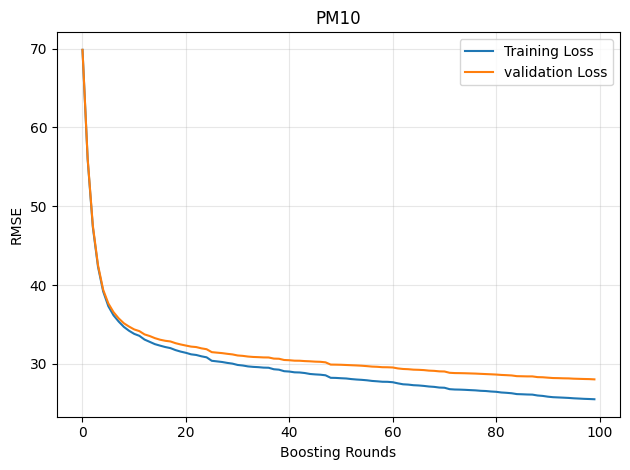

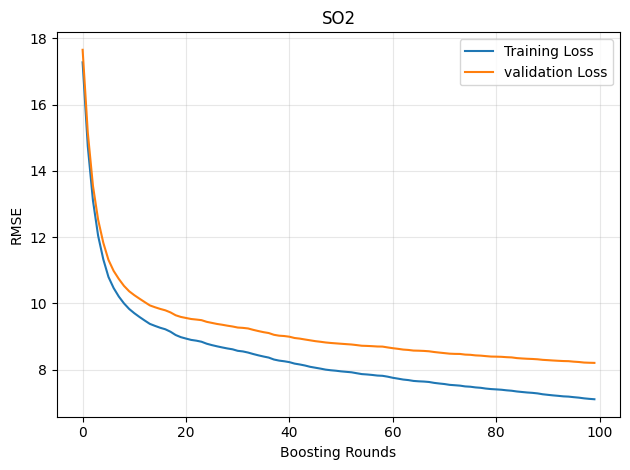

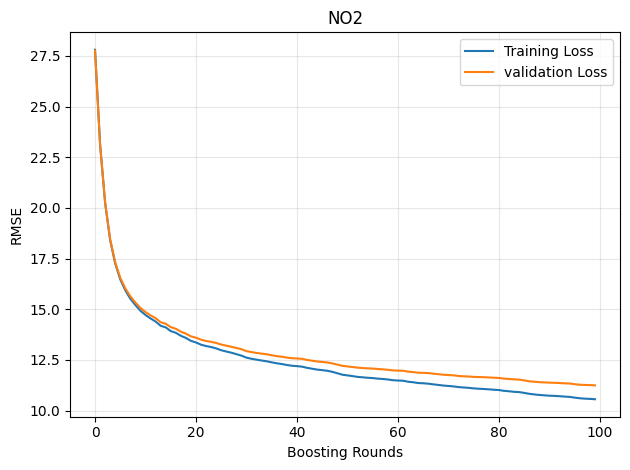

,MAE,RMSE,R^2
PM10 Training,16.17,4.02,0.92
PM10 Validation,17.08,4.13,0.91
SO2 Training,4.28,2.07,0.89
SO2 Validation,4.63,2.15,0.86
NO2 Training,7.64,2.76,0.91
NO2 Validation,8.07,2.84,0.90


In [ ]:
# Getting the models and evaluting
xgb_pm10 = fit_and_evaluate(X_xgb_pm10_train, y_xgb_pm10_train, X_xgb_pm10_val, y_xgb_pm10_val, title='PM10')
xgb_so2 = fit_and_evaluate(X_xgb_so2_train, y_xgb_so2_train, X_xgb_so2_val, y_xgb_so2_val, title='SO2')
xgb_no2 = fit_and_evaluate(X_xgb_no2_train, y_xgb_no2_train, X_xgb_no2_val, y_xgb_no2_val, title='NO2')

# Setting the errors for a dataframe
baseline_evaluation['MAE'] = mae
baseline_evaluation['RMSE'] = rmse
baseline_evaluation['R^2'] = r2

# Print the dataframe showing different errors
baseline_evaluation

## Hyperparameter Optimization

In [ ]:
"""
# Parameter grid for hyparameter optimization
param_grid = {
    'max_depth': [4, 6, 8],
    'min_child_weight': [1, 3, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [80, 150, 200, 300]
}


xgb_so2 = XGBRegressor(random_state=42, early_stopping_rounds=20)
xgb_so2_grid = GridSearchCV(xgb_so2, param_grid, cv=3, n_jobs=-1, scoring='r2')
xgb_so2_grid.fit(X_xgb_so2_train, y_xgb_so2_train, eval_set=[(X_xgb_so2_train, y_xgb_pm10_train), (X_xgb_so2_val, y_xgb_so2_val)])
print(xgb_so2_grid.best_params_)

xgb_no2 = XGBRegressor(random_state=42, early_stopping_rounds=20)
xgb_no2_grid = GridSearchCV(xgb_no2, param_grid, cv=3, n_jobs=-1, scoring='r2')
xgb_no2_grid.fit(X_xgb_no2_train, y_xgb_no2_train, eval_set=[(X_xgb_no2_train, y_xgb_no2_train), (X_xgb_no2_val, y_xgb_no2_val)])
print(xgb_no2_grid.best_params_)

xgb_pm10 = XGBRegressor(random_state=42, early_stopping_rounds=20)
xgb_pm10_grid = GridSearchCV(xgb_pm10, param_grid, cv=3, n_jobs=-1, scoring='r2')
xgb_pm10_grid.fit(X_xgb_pm10_train, y_xgb_pm10_train, eval_set=[(X_xgb_pm10_train, y_xgb_pm10_train), (X_xgb_pm10_val, y_xgb_pm10_val)])
print(xgb_pm10_grid.best_params_)
"""

"\n# Parameter grid for hyparameter optimization\nparam_grid = {\n    'max_depth': [4, 6, 8],\n    'min_child_weight': [1, 3, 5],\n    'learning_rate': [0.01, 0.05, 0.1],\n    'n_estimators': [80, 150, 200, 300]\n}\n\n\nxgb_so2 = XGBRegressor(random_state=42, early_stopping_rounds=20)\nxgb_so2_grid = GridSearchCV(xgb_so2, param_grid, cv=3, n_jobs=-1, scoring='r2')\nxgb_so2_grid.fit(X_xgb_so2_train, y_xgb_so2_train, eval_set=[(X_xgb_so2_train, y_xgb_pm10_train), (X_xgb_so2_val, y_xgb_so2_val)])\nprint(xgb_so2_grid.best_params_)\n\nxgb_no2 = XGBRegressor(random_state=42, early_stopping_rounds=20)\nxgb_no2_grid = GridSearchCV(xgb_no2, param_grid, cv=3, n_jobs=-1, scoring='r2')\nxgb_no2_grid.fit(X_xgb_no2_train, y_xgb_no2_train, eval_set=[(X_xgb_no2_train, y_xgb_no2_train), (X_xgb_no2_val, y_xgb_no2_val)])\nprint(xgb_no2_grid.best_params_)\n\nxgb_pm10 = XGBRegressor(random_state=42, early_stopping_rounds=20)\nxgb_pm10_grid = GridSearchCV(xgb_pm10, param_grid, cv=3, n_jobs=-1, scoring='r2')

**From gridsearchcv, the best parameters:**

**For PM10:**
n_estimators=200, learning_rate=0.1, max_depth=8, min_child_weight=1

**For SO2**
n_estimators=200, learning_rate=0.1, max_depth=8, min_child_weight=1

**For NO2**
n_estimators=300, learning_rate=0.1, max_depth=8, min_child_weight=1

In [ ]:
# Initiating a dataframe to absorb all the metrics
best_model_evaluation = pd.DataFrame(
    index=["PM10", "SO2", "NO2"],
    columns=["MAE", "RMSE", "R^2"]
)

mae = []
r2 = []
rmse = []

# Function for fitting and evaluation
def fit_best_model(X_train, y_train, X_val, y_val, X_test, y_test, title, n_estimators, learning_rate, max_depth, min_child_weight):
  """
  This function fits training
  into the model, obtain some evaluation metrics for testing
  dataset and evalutes the predictions.
  """

  # Fit model
  xgb = XGBRegressor(random_state=42, n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, min_child_weight=min_child_weight, early_stopping_rounds=30)
  xgb.fit(X_train, y_train, verbose=False, eval_set=[(X_train, y_train), (X_val, y_val)])

  # Predict
  y_pred = xgb.predict(X_test)

  # Predict evaluation metrics for training set
  mae.append(round(mean_absolute_error(y_test, y_pred), 2))
  rmse.append(round(np.sqrt(mean_absolute_error(y_test, y_pred)), 2))
  r2.append(round(r2_score(y_test, y_pred), 2))

  # Plotting feature importance
  plot_importance(xgb, importance_type='gain');

  # Plotting actual vs. predicted pollutant levels
  plt.figure(dpi=100)
  plt.plot(y_pred[:100], label='Predicted Levels', color='red')
  plt.plot(y_test[:100].values, label='Actual Levels', color='green')
  plt.ylabel('Pollutant Level')
  plt.grid(alpha=0.3)
  plt.title(title)
  plt.legend()
  plt.tight_layout()
  plt.savefig(f'{title}_actual_vs._predicted.png', dpi=150)
  plt.show();

  # Getting the evaluation results for training and validation set
  evals_result = xgb.evals_result()

  # Plotting training vs. validation rmse
  plt.figure(dpi=100)
  plt.plot(evals_result['validation_0']['rmse'], label='Training Loss')
  plt.plot(evals_result['validation_1']['rmse'], label='validation Loss')
  plt.title(title)
  plt.xlabel('Boosting Rounds')
  plt.ylabel('RMSE')
  plt.legend()
  plt.grid(alpha=0.3)
  plt.tight_layout()
  plt.savefig(f'{title}_training_vs._validation_loss.png', dpi=150)
  plt.show();

  return xgb

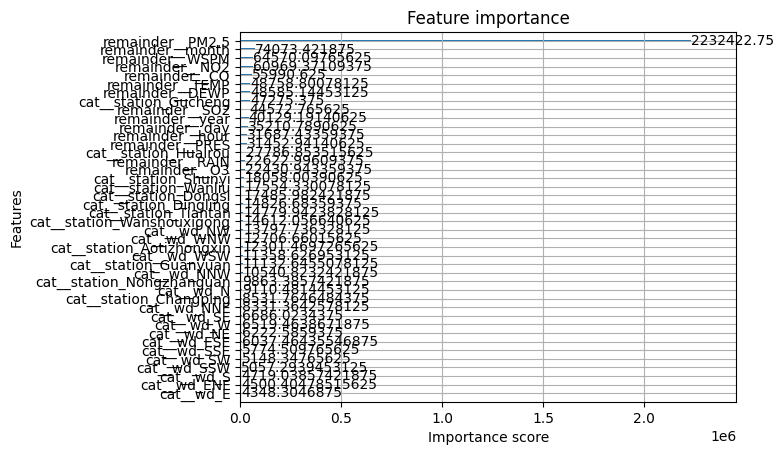

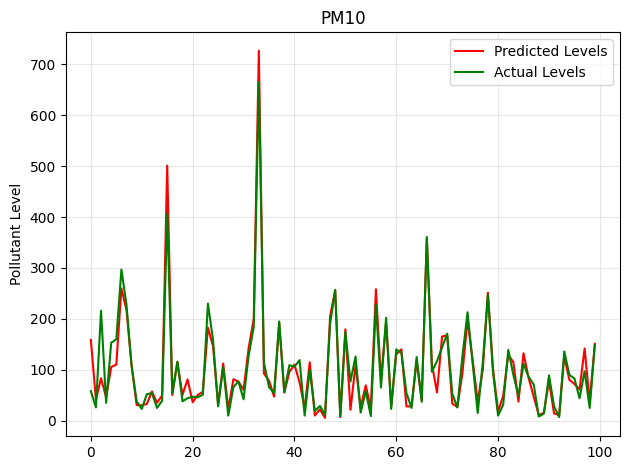

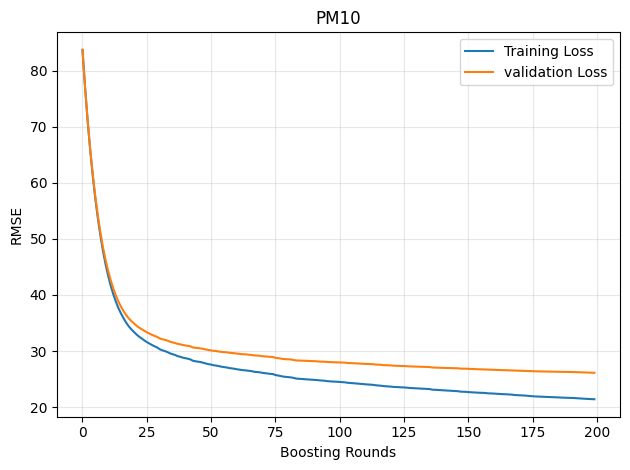

In [ ]:
# Getting the models and evaluting
xgb_pm10 = fit_best_model(X_xgb_pm10_train, y_xgb_pm10_train, X_xgb_pm10_val, y_xgb_pm10_val, X_xgb_pm10_test, y_xgb_pm10_test,
                          title='PM10', n_estimators=200, learning_rate=0.1, max_depth=8, min_child_weight=1)

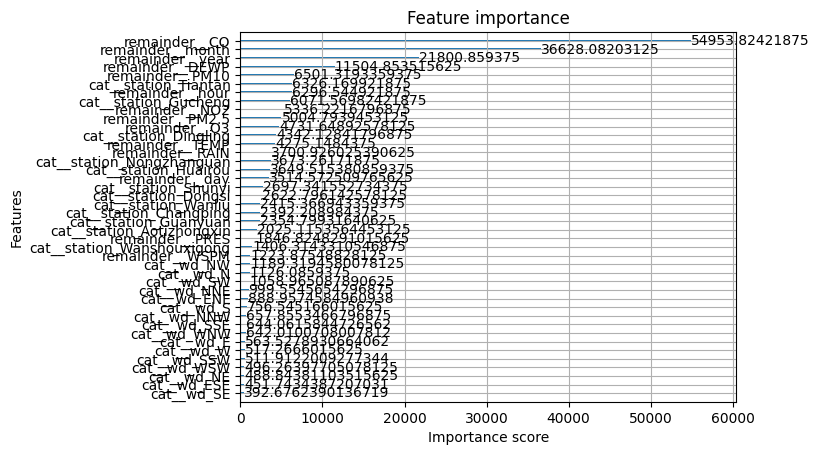

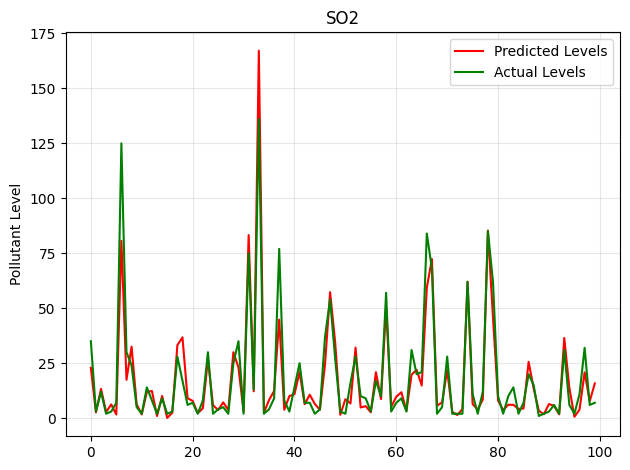

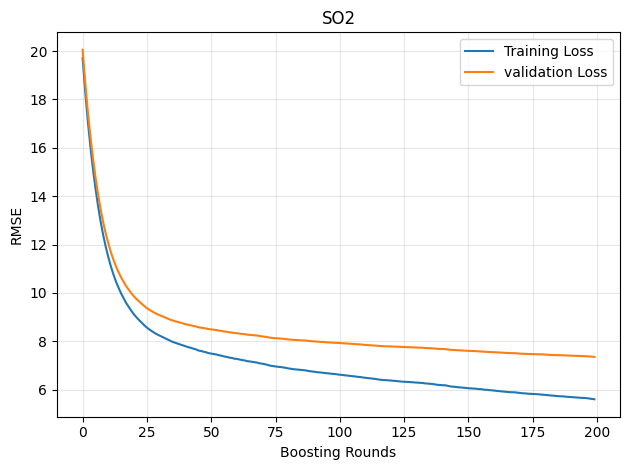

In [ ]:
# Model evaluation
xgb_so2 = fit_best_model(X_xgb_so2_train, y_xgb_so2_train, X_xgb_so2_val, y_xgb_so2_val, X_xgb_so2_test, y_xgb_so2_test,
                         title='SO2', n_estimators=200, learning_rate=0.1, max_depth=8, min_child_weight=1)

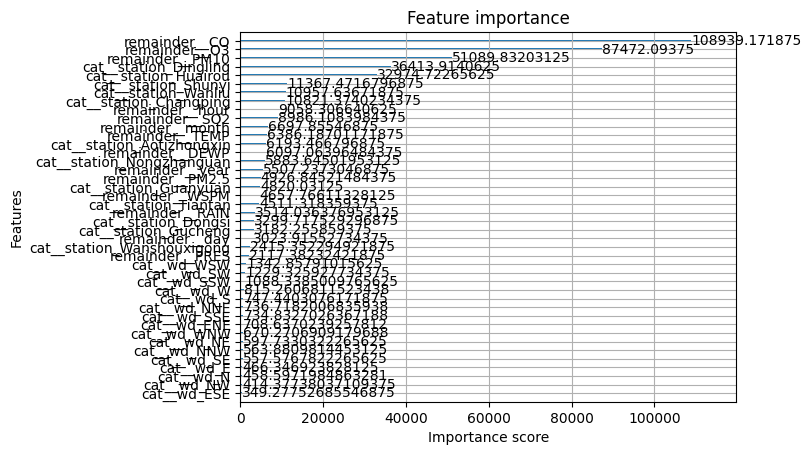

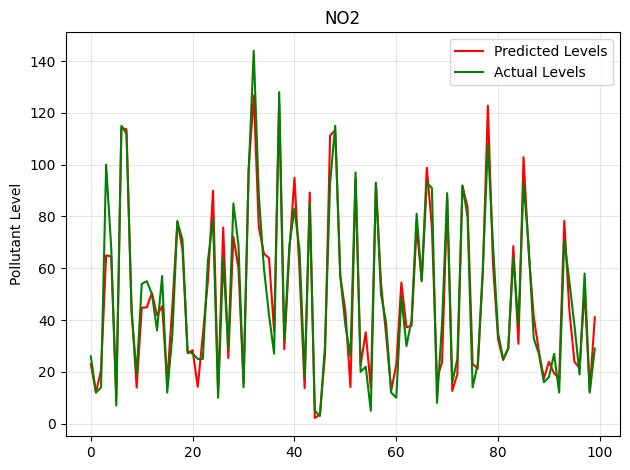

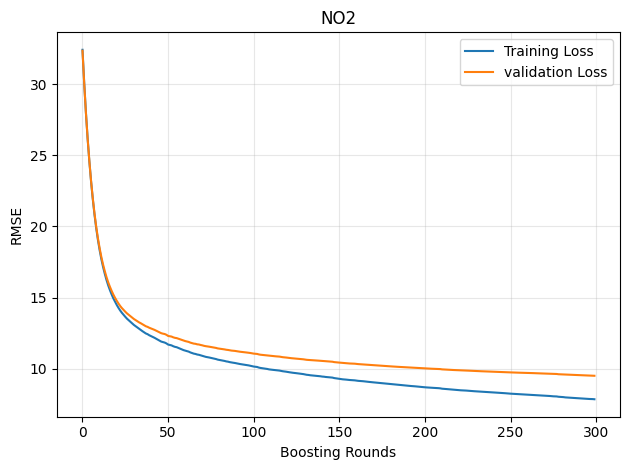

In [ ]:
# Model evaluation
xgb_no2 = fit_best_model(X_xgb_no2_train, y_xgb_no2_train, X_xgb_no2_val, y_xgb_no2_val, X_xgb_no2_test, y_xgb_no2_test,
                         title='NO2', n_estimators=300, learning_rate=0.1, max_depth=8, min_child_weight=1)

In [ ]:
# Setting the errors for a dataframe
best_model_evaluation['MAE'] = mae
best_model_evaluation['RMSE'] = rmse
best_model_evaluation['R^2'] = r2

In [ ]:
# Print the dataframe showing different errors
best_model_evaluation

,MAE,RMSE,R^2
PM10,15.76,3.97,0.91
SO2,3.99,2.00,0.89
NO2,6.77,2.60,0.93
